🤖 NOTEBOOK 3: MODELING AND HYPERPARAMETER TUNING
📥 Loading preprocessed data...
Training set: (1176, 30)
Test set: (294, 30)
Training attrition rate: 16.16%

🎯 SETTING UP HYPERPARAMETER TUNING...

🚀 TRAINING MODELS WITH GRID SEARCH...
  🔹 Training Logistic Regression...
    ✅ Best params: {'C': 10, 'class_weight': {0: 1, 1: 2}, 'max_iter': 1000, 'solver': 'liblinear'}
    ✅ Best CV score: 0.5463
  🔹 Training Random Forest...
    ✅ Best params: {'class_weight': 'balanced_subsample', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
    ✅ Best CV score: 0.5298
  🔹 Training Gradient Boosting...
    ✅ Best params: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 150}
    ✅ Best CV score: 0.5332
  🔹 Creating Ensemble Model...
✅ All models trained and optimized

📊 QUICK PERFORMANCE CHECK ON TEST SET:
Model                AUC-PR   AUC-ROC 
----------------------------------------------------------------------
Logistic Regressio

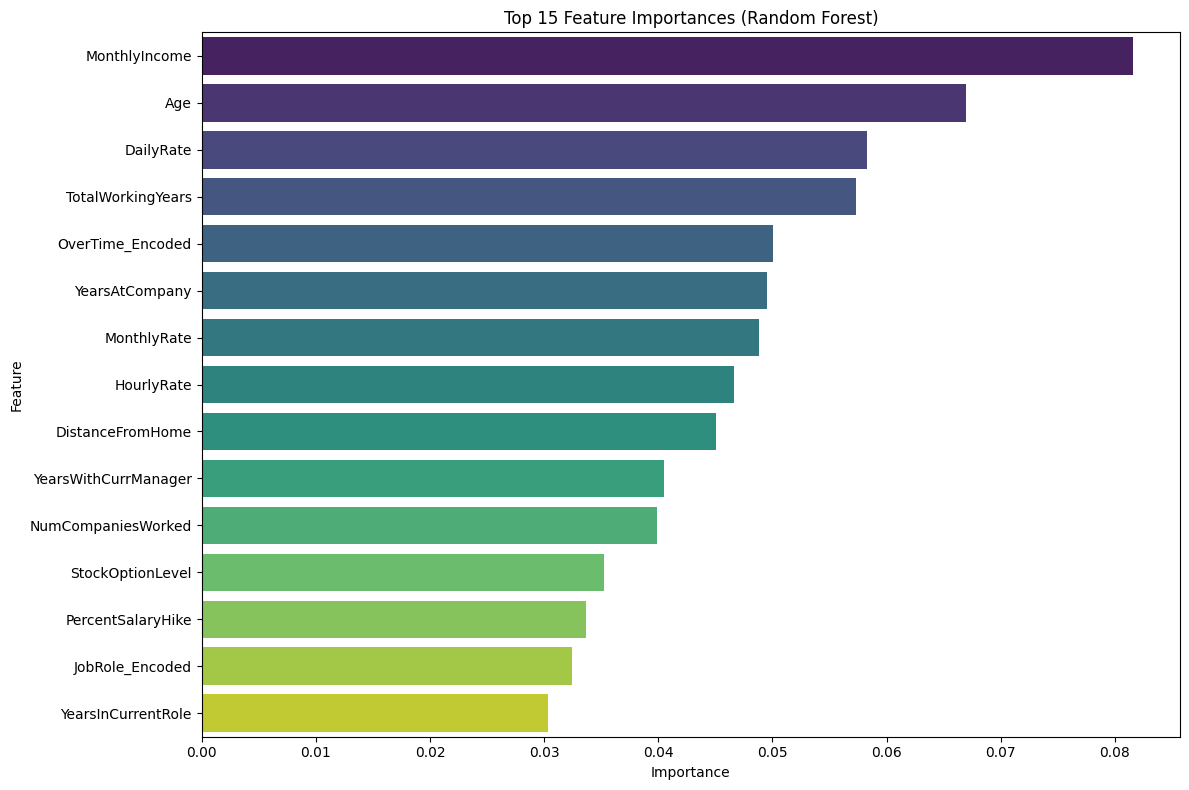


💾 SAVING TRAINED MODELS...
  ✅ Saved Logistic Regression as model_logistic_regression.pkl
  ✅ Saved Random Forest as model_random_forest.pkl
  ✅ Saved Gradient Boosting as model_gradient_boosting.pkl
  ✅ Saved Ensemble as model_ensemble.pkl
✅ Modeling and hyperparameter tuning completed successfully!


In [3]:
# =============================================================================
# NOTEBOOK 3: MODELING AND HYPERPARAMETER TUNING
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
import warnings
warnings.filterwarnings('ignore')

print("🤖 NOTEBOOK 3: MODELING AND HYPERPARAMETER TUNING")
print("=" * 50)

# Load preprocessed data
print("📥 Loading preprocessed data...")
X_train_scaled = joblib.load('X_train_scaled.pkl')
X_test_scaled = joblib.load('X_test_scaled.pkl')
y_train = joblib.load('y_train.pkl')
y_test = joblib.load('y_test.pkl')

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Training attrition rate: {(y_train.sum() / len(y_train) * 100):.2f}%")

# Define parameter grids for each model
print("\n🎯 SETTING UP HYPERPARAMETER TUNING...")

param_grids = {
    'logistic': {
        'C': [0.1, 1, 10],
        'class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}],
        'solver': ['liblinear'],
        'max_iter': [1000]
    },
    'random_forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 15, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'class_weight': ['balanced', 'balanced_subsample']
    },
    'gradient_boosting': {
        'n_estimators': [100, 150],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 4],
        'min_samples_split': [2, 5]
    }
}

# Train individual models with cross-validation
print("\n🚀 TRAINING MODELS WITH GRID SEARCH...")

models = {}
cv_scores = {}

# Logistic Regression
print("  🔹 Training Logistic Regression...")
lr = LogisticRegression(random_state=42)
lr_grid = GridSearchCV(lr, param_grids['logistic'], cv=5, scoring='average_precision', n_jobs=-1)
lr_grid.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr_grid.best_estimator_
cv_scores['Logistic Regression'] = lr_grid.best_score_
print(f"    ✅ Best params: {lr_grid.best_params_}")
print(f"    ✅ Best CV score: {lr_grid.best_score_:.4f}")

# Random Forest
print("  🔹 Training Random Forest...")
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, param_grids['random_forest'], cv=5, scoring='average_precision', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)
models['Random Forest'] = rf_grid.best_estimator_
cv_scores['Random Forest'] = rf_grid.best_score_
print(f"    ✅ Best params: {rf_grid.best_params_}")
print(f"    ✅ Best CV score: {rf_grid.best_score_:.4f}")

# Gradient Boosting
print("  🔹 Training Gradient Boosting...")
gb = GradientBoostingClassifier(random_state=42)
gb_grid = GridSearchCV(gb, param_grids['gradient_boosting'], cv=5, scoring='average_precision', n_jobs=-1)
gb_grid.fit(X_train_scaled, y_train)
models['Gradient Boosting'] = gb_grid.best_estimator_
cv_scores['Gradient Boosting'] = gb_grid.best_score_
print(f"    ✅ Best params: {gb_grid.best_params_}")
print(f"    ✅ Best CV score: {gb_grid.best_score_:.4f}")

# Ensemble Model (Weighted Voting)
print("  🔹 Creating Ensemble Model...")
ensemble = VotingClassifier(
    estimators=[
        ('lr', models['Logistic Regression']),
        ('rf', models['Random Forest']),
        ('gb', models['Gradient Boosting'])
    ],
    voting='soft',
    weights=[cv_scores['Logistic Regression'], cv_scores['Random Forest'], cv_scores['Gradient Boosting']]
)

models['Ensemble'] = ensemble
models['Ensemble'].fit(X_train_scaled, y_train)

print("✅ All models trained and optimized")

# Quick performance check
print("\n📊 QUICK PERFORMANCE CHECK ON TEST SET:")
print("=" * 70)
print(f"{'Model':<20} {'AUC-PR':<8} {'AUC-ROC':<8}")
print("-" * 70)

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    auc_pr = average_precision_score(y_test, y_pred_proba)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    print(f"{name:<20} {auc_pr:.4f}  {auc_roc:.4f}")

print("=" * 70)

# Feature Importance Analysis
print("\n🔍 FEATURE IMPORTANCE ANALYSIS")

# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': models['Random Forest'].feature_importances_
}).sort_values('Importance', ascending=False)

print("🚀 TOP 10 FEATURES (Random Forest):")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"  {i:2d}. {row['Feature']}: {row['Importance']:.4f}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save trained models
print("\n💾 SAVING TRAINED MODELS...")
for name, model in models.items():
    filename = f'model_{name.replace(" ", "_").lower()}.pkl'
    joblib.dump(model, filename)
    print(f"  ✅ Saved {name} as {filename}")

# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)

print("✅ Modeling and hyperparameter tuning completed successfully!")